### <b>Butterfly classification

In [1]:
import numpy as np
import pandas as pd
import os

data_dir = "/mnt/d/MyProject/Datasets/Butterflies"

train_df = pd.read_csv(data_dir + "/train.csv")
test_df = pd.read_csv(data_dir + "/test.csv")
print(train_df.shape)
print(test_df.shape)
train_df.head()

(6499, 2)
(2786, 1)


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [2]:
import tensorflow as tf
from keras import (models , layers , optimizers , preprocessing , initializers)
from sklearn.preprocessing import StandardScaler , LabelEncoder
import cv2
import matplotlib.pyplot as plt


2025-04-12 01:09:01.872997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 01:09:01.885812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744391341.898421   24299 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744391341.901487   24299 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744391341.910748   24299 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
from concurrent.futures import ThreadPoolExecutor

# prepare data
data_folder = data_dir + "/train/"

suffix = train_df.to_numpy()[: , 0]
suffix = data_folder + suffix

def load_image(arr: np.ndarray):

    def process_image(path):
        img = preprocessing.image.load_img(path, target_size=(150, 150))
        img = preprocessing.image.img_to_array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB format
        return img

    with ThreadPoolExecutor() as executor:
        images = list(executor.map(process_image, arr))

    images = np.array(images)
    return images
"""extract images and labels"""
train_images = load_image(suffix)
labels = train_df.to_numpy()[: , 1]

print(train_images[:1])
labels[:5]

[[[[ 31.  43.  25.]
   [ 29.  42.  26.]
   [ 29.  42.  26.]
   ...
   [ 18.  40.  28.]
   [ 23.  47.  35.]
   [ 33.  59.  46.]]

  [[ 30.  45.  24.]
   [ 27.  43.  25.]
   [ 25.  44.  25.]
   ...
   [ 39.  64.  54.]
   [ 42.  69.  59.]
   [ 48.  78.  67.]]

  [[ 28.  45.  24.]
   [ 25.  44.  25.]
   [ 24.  43.  24.]
   ...
   [ 50.  77.  68.]
   [ 52.  81.  72.]
   [ 53.  87.  77.]]

  ...

  [[ 59.  95.  59.]
   [ 66. 110.  71.]
   [ 73. 120.  82.]
   ...
   [ 23.  58.  38.]
   [ 26.  65.  44.]
   [ 26.  70.  47.]]

  [[ 61.  97.  61.]
   [ 63. 107.  68.]
   [ 75. 122.  84.]
   ...
   [ 22.  59.  39.]
   [ 24.  63.  41.]
   [ 21.  67.  44.]]

  [[ 69. 104.  70.]
   [ 68. 111.  74.]
   [ 81. 128.  90.]
   ...
   [ 19.  61.  38.]
   [ 19.  65.  42.]
   [ 21.  69.  43.]]]]


array(['SOUTHERN DOGFACE', 'ADONIS', 'BROWN SIPROETA', 'MONARCH',
       'GREEN CELLED CATTLEHEART'], dtype=object)

<b>View some img

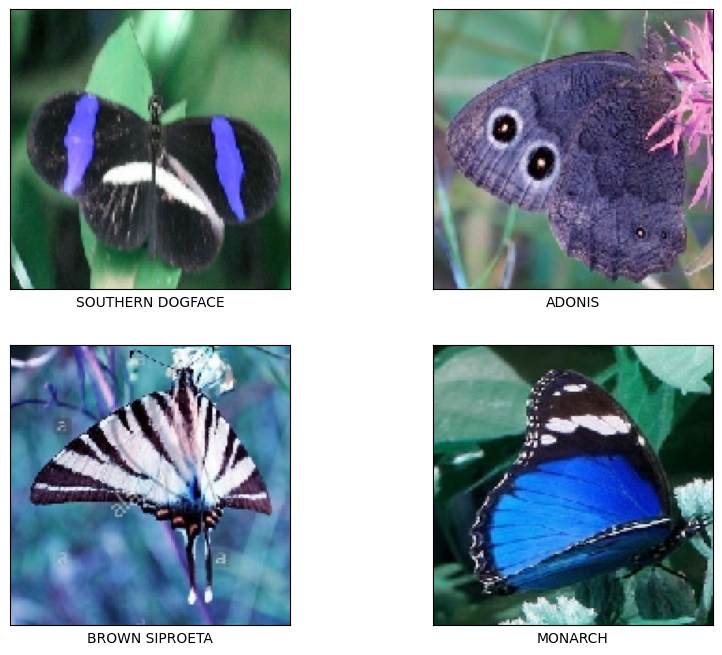

In [4]:


plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2 , 2 , i + 1)
    plt.imshow(train_images[i+50].astype('uint8'), cmap=None)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[i])    

plt.show()

DATA ENCODE

In [5]:
print(labels)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
n_classes = len(label_encoder.classes_)

print(f"num classes: {n_classes}")

['SOUTHERN DOGFACE' 'ADONIS' 'BROWN SIPROETA' ... 'APPOLLO'
 'ELBOWED PIERROT' 'ATALA']
num classes: 75


In [6]:
train_images = train_images / 255

In [7]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, labels, test_size=0.2, random_state=42  # 20% for validation
)
print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")

Training images: 5199, Validation images: 1300


<b>BUILDING MODEL

In [16]:
model = models.Sequential([
    layers.InputLayer((150,150,3)),

    layers.Conv2D(64 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.05),

    layers.Conv2D(128 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.05),

    layers.Conv2D(256 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.08),

    layers.Conv2D(512 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.08),

    layers.Flatten(),

    layers.Dense(64 , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.Dropout(0.1),

    layers.Dense(128 , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.Dropout(0.1),

    layers.Dense(256 , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.Dropout(0.1),

    layers.Dense(n_classes , activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             

 Total params: 3,221,131 (12.29 MB)

 Trainable params: 3,219,211 (12.28 MB)

 Non-trainable params: 1,920 (7.50 KB)

<b>Compile model

In [17]:
model.compile(optimizer=optimizers.Adam(0.0005) , loss="sparse_categorical_crossentropy" , metrics=["accuracy"])

<b>Use Image Data Generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

datagen = ImageDataGenerator(
    rotation_range=10,         # Reduce rotation
    width_shift_range=0.1,     # Reduce horizontal shift
    height_shift_range=0.1,    # Reduce vertical shift
    shear_range=0.1,           # Reduce shearing
    zoom_range=0.1,            # Reduce zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [20]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),  # Augmented training data
    validation_data=(val_images, val_labels),          # Validation data
    epochs=200,                                         # Number of epochs
    steps_per_epoch=len(train_images) // 64,          # Steps per epoch
    validation_steps=len(val_images) // 64,           # Validation steps
    callbacks=callbacks                                  # Add callbacks like EarlyStopping if needed
)

Epoch 1/200


2025-04-12 00:28:08.796588: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4033', 8300 bytes spill stores, 8520 bytes spill loads

2025-04-12 00:28:09.057012: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4033', 140 bytes spill stores, 140 bytes spill loads

2025-04-12 00:28:09.212379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4581', 320 bytes spill stores, 320 bytes spill loads

2025-04-12 00:28:09.507951: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4581', 64 bytes spill stores, 64 bytes spill loads

2025-04-12 00:28:09.532205: I ex

81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.0411 - loss: 4.8867 - val_accuracy: 0.0438 - val_loss: 4.2878 - learning_rate: 5.0000e-04
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0781 - loss: 4.5854 - val_accuracy: 0.0369 - val_loss: 4.2815 - learning_rate: 5.0000e-04
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.1067 - loss: 4.0472 - val_accuracy: 0.0715 - val_loss: 4.1228 - learning_rate: 5.0000e-04
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1094 - loss: 3.8931 - val_accuracy: 0.0685 - val_loss: 4.1203 - learning_rate: 5.0000e-04
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.1763 - loss: 3.5568 - val_accuracy: 0.0754 - val_loss: 4.0046 - learning_rate: 5.0000e-04
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1562 - loss: 3.5952 - val_accuracy: 0.0762 - val_loss: 3.9900 - learning_rate: 5.0000e-04
Epoch 7/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.2110 

<b>Save model

In [21]:
model.save("Butterfly.keras")

In [22]:
print(history.history)

{'accuracy': [0.05920155718922615, 0.078125, 0.11762414872646332, 0.109375, 0.17799416184425354, 0.15625, 0.23174293339252472, 0.265625, 0.2769230902194977, 0.28125, 0.3123661279678345, 0.375, 0.35306718945503235, 0.421875, 0.38909444212913513, 0.34375, 0.41421616077423096, 0.453125, 0.4607594907283783, 0.515625, 0.48003894090652466, 0.515625, 0.5106134414672852, 0.484375, 0.5201557874679565, 0.46875, 0.5357351303100586, 0.53125, 0.5575462579727173, 0.484375, 0.5684518218040466, 0.546875, 0.577994167804718, 0.5625, 0.5902628898620605, 0.5625, 0.6188899874687195, 0.46875, 0.6327166557312012, 0.625, 0.6253164410591125, 0.71875, 0.641480028629303, 0.71875, 0.6508276462554932, 0.578125, 0.6599805355072021, 0.578125, 0.6654332876205444, 0.625, 0.6794547438621521, 0.59375, 0.6911392211914062, 0.703125, 0.6878286004066467, 0.671875, 0.6925024390220642, 0.671875, 0.6915287375450134, 0.609375, 0.6993184089660645, 0.6875, 0.7036027312278748, 0.703125, 0.703797459602356, 0.65625, 0.70613437891006

<b>Visualize training process

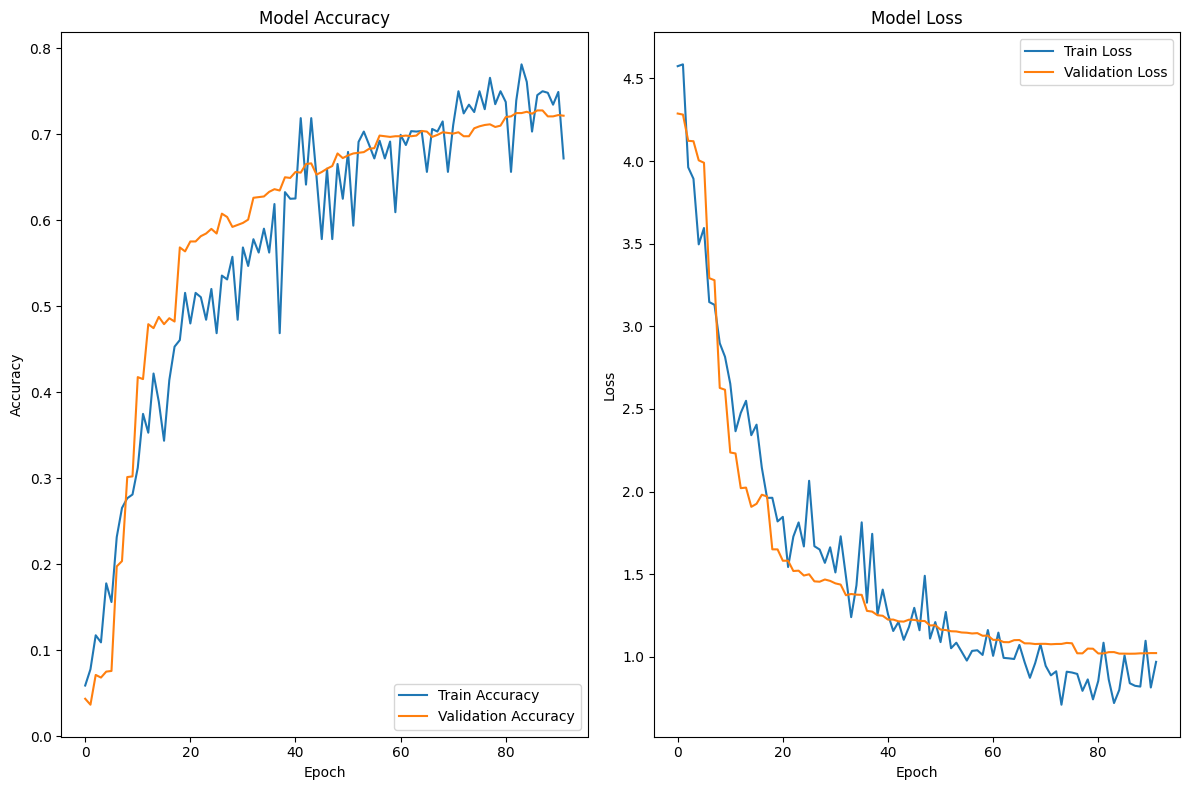

In [23]:
plt.figure(figsize=(12, 8))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### <b>Experiment on Pre trained model

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(n_classes, activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    validation_data=(val_images, val_labels),
    epochs=50,
    steps_per_epoch=len(train_images) // 64,
    validation_steps=len(val_images) // 64,
    callbacks=callbacks
)

/tmp/ipykernel_18171/1248413842.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
/home/zihao/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1744390728.663844   18671 service.cc:152] XLA service 0x7f12540149a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744390728.663880   18671 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-12 00:58:48.750836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744390729.242459   18671 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-12 00:58:50.370799: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 468 bytes spill stores, 468 bytes spill loads

2025-04-12 00:58:50.495534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

 3/81 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.0061 - loss: 5.3486      

I0000 00:00:1744390738.282797   18671 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/81 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.0178 - loss: 4.7703

2025-04-12 00:59:06.628936: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 112 bytes spill stores, 112 bytes spill loads

2025-04-12 00:59:06.633709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 8 bytes spill stores, 8 bytes spill loads

2025-04-12 00:59:06.638341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990_0', 176 bytes spill stores, 524 bytes spill loads

2025-04-12 00:59:06.658780: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 12 bytes spill stores, 12 bytes spill loads

2025-04-12 00:59:06.769457: I extern

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.0186 - loss: 4.7173

2025-04-12 00:59:14.837698: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165_0', 108 bytes spill stores, 108 bytes spill loads

2025-04-12 00:59:14.891905: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 4 bytes spill stores, 4 bytes spill loads

2025-04-12 00:59:15.154497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 644 bytes spill stores, 644 bytes spill loads

2025-04-12 00:59:15.276079: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 904 bytes spill stores, 900 bytes spill loads

2025-04-12 00:59:15.399909: I exte

81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.0187 - loss: 4.7144 - val_accuracy: 0.0500 - val_loss: 4.1465 - learning_rate: 1.0000e-04
Epoch 2/50
 1/81 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0156 - loss: 4.3406

/home/zihao/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0156 - loss: 4.3406 - val_accuracy: 0.0515 - val_loss: 4.1444 - learning_rate: 1.0000e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.0398 - loss: 4.1821 - val_accuracy: 0.1431 - val_loss: 3.9216 - learning_rate: 1.0000e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0625 - loss: 4.0394 - val_accuracy: 0.1431 - val_loss: 3.9178 - learning_rate: 1.0000e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.0948 - loss: 3.9518 - val_accuracy: 0.2362 - val_loss: 3.6016 - learning_rate: 1.0000e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1875 - loss: 3.6980 - val_accuracy: 0.2392 - val_loss: 3.5970 - learning_rate: 1.0000e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.1405 - loss: 3.6776 - val_accuracy: 0.3477 - val_loss: 3.1943 - learning_rate: 1.0000e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2344 - loss: 3

In [14]:
model.save("Butterfly_TransferLearning.keras")

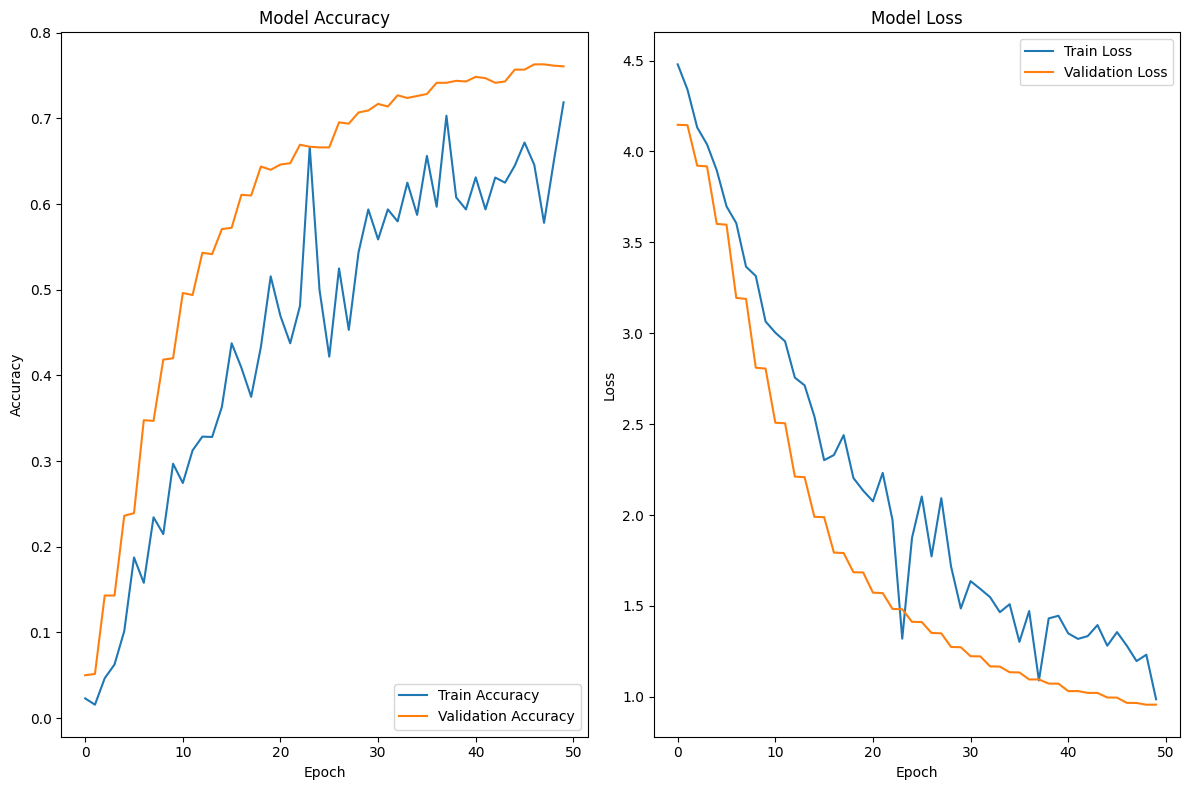

In [12]:
# Visualize training process
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### <b>Fine Tuning

In [12]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model = load_model("Butterfly_TransferLearning.keras")

# Unfreeze the base model for fine-tuning
model.layers[0].trainable = True  # Assuming the base model is the first layer

# Compile the model with a lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    validation_data=(val_images, val_labels),
    epochs=20,  # Fine-tune for a few more epochs
    steps_per_epoch=len(train_images) // 64,
    validation_steps=len(val_images) // 64,
    callbacks=callbacks
)

# Save the fine-tuned model
model.save("Butterfly_FineTuned.keras")

/home/zihao/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1744391424.908445   24571 service.cc:152] XLA service 0x7ff93c002060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744391424.908480   24571 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-12 01:10:24.967437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744391425.443931   24571 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-12 01:10:26.802425: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 468 bytes spill stores, 468 bytes spill loads

2025-04-12 01:10:26.894913: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

 3/81 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.6701 - loss: 1.2190  

I0000 00:00:1744391434.515242   24571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/81 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6754 - loss: 1.2018

2025-04-12 01:10:38.387199: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 12 bytes spill stores, 12 bytes spill loads

2025-04-12 01:10:38.466824: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 8 bytes spill stores, 8 bytes spill loads

2025-04-12 01:10:38.567894: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990', 112 bytes spill stores, 112 bytes spill loads

2025-04-12 01:10:38.587044: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1990_0', 176 bytes spill stores, 524 bytes spill loads

2025-04-12 01:10:39.112162: I extern

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6715 - loss: 1.1882

2025-04-12 01:10:51.928471: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 460 bytes spill stores, 460 bytes spill loads

2025-04-12 01:10:52.033901: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 16 bytes spill stores, 16 bytes spill loads

2025-04-12 01:10:52.144606: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 644 bytes spill stores, 644 bytes spill loads

2025-04-12 01:10:52.169087: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1165', 64 bytes spill stores, 64 bytes spill loads

2025-04-12 01:10:52.180077: I extern

81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.6714 - loss: 1.1883 - val_accuracy: 0.7715 - val_loss: 0.9485 - learning_rate: 1.0000e-05
Epoch 2/20
 1/81 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6562 - loss: 1.2155

/home/zihao/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6562 - loss: 1.2155 - val_accuracy: 0.7715 - val_loss: 0.9484 - learning_rate: 1.0000e-05
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6702 - loss: 1.1707 - val_accuracy: 0.7731 - val_loss: 0.9419 - learning_rate: 1.0000e-05
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7969 - loss: 0.8976 - val_accuracy: 0.7731 - val_loss: 0.9418 - learning_rate: 1.0000e-05
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.6723 - loss: 1.1627 - val_accuracy: 0.7769 - val_loss: 0.9366 - learning_rate: 1.0000e-05
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7344 - loss: 1.2834 - val_accuracy: 0.7762 - val_loss: 0.9367 - learning_rate: 1.0000e-05
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6757 - loss: 1.1399 - val_accuracy: 0.7723 - val_loss: 0.9354 - learning_rate: 1.0000e-05
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6094 - loss: 1

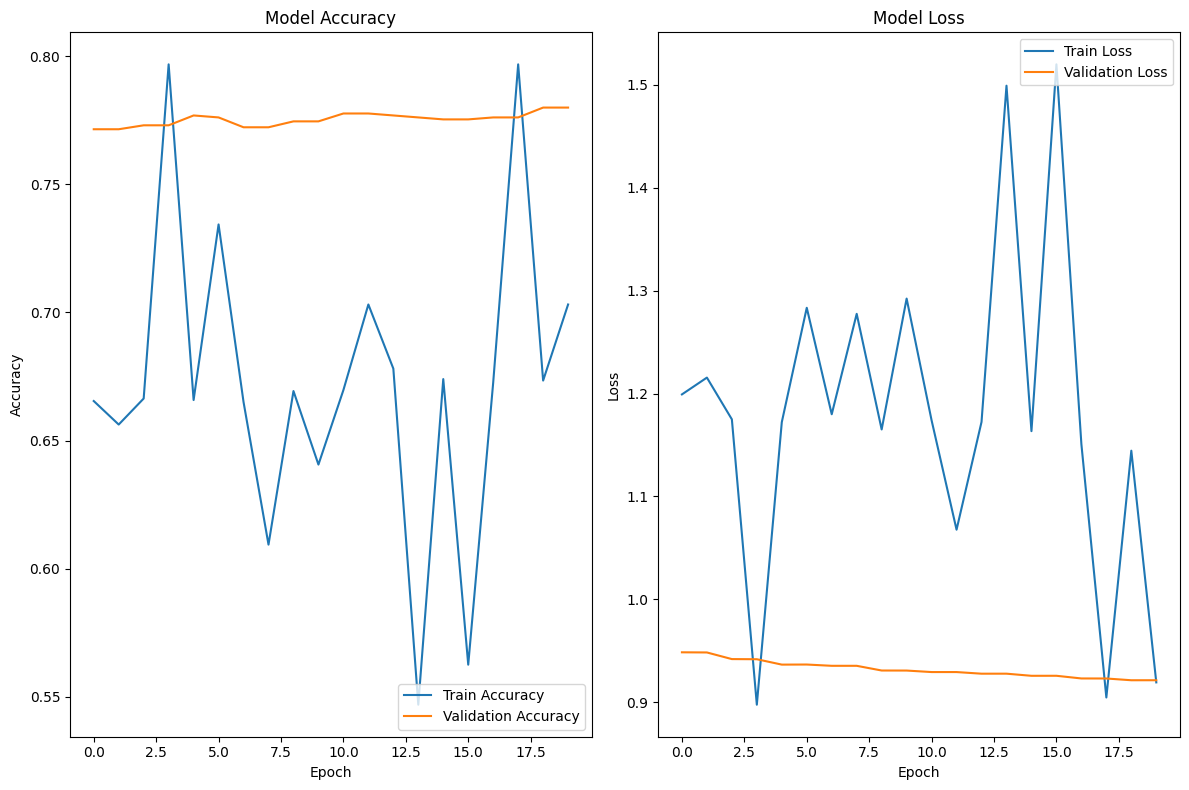

In [14]:
# Visualize training process
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()